In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from copy import deepcopy

In [292]:
seed = 42

# Data preparation

In [293]:
df = pd.read_csv("train_data.csv")

In [294]:
def clean_df(df):
    return df

def prep_features(df: pd.DataFrame):
    df = df.drop(["id", "status_admitere"], axis=1, errors='ignore')

    # drop irrelevant features
    df = df.drop(["gen"], axis=1)

    # dummy encoding
    dummies = pd.get_dummies(df["judet"], prefix="judet")
    df = pd.concat([df, dummies], axis=1)

    df = df.select_dtypes(exclude='object')
    return df

In [295]:
df = pd.read_csv("train_data.csv")
df = clean_df(df)

df_train = prep_features(df)

In [296]:
df_train.head()

,Unnamed: 0,NT,MEV,MATE,MGIM,judet_AB,judet_AG,judet_AR,judet_B,judet_BC,...,judet_SB,judet_SJ,judet_SM,judet_SV,judet_TL,judet_TM,judet_TR,judet_VL,judet_VN,judet_VS
0,0,4.91,8.82,6.23,6.85,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,9.50,7.31,8.97,8.36,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,2,6.23,8.63,5.40,8.54,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,1.35,9.49,9.06,5.59,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,4,1.82,6.71,8.67,8.34,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Exploratory data analysis

<Axes: xlabel='judet', ylabel='Count'>

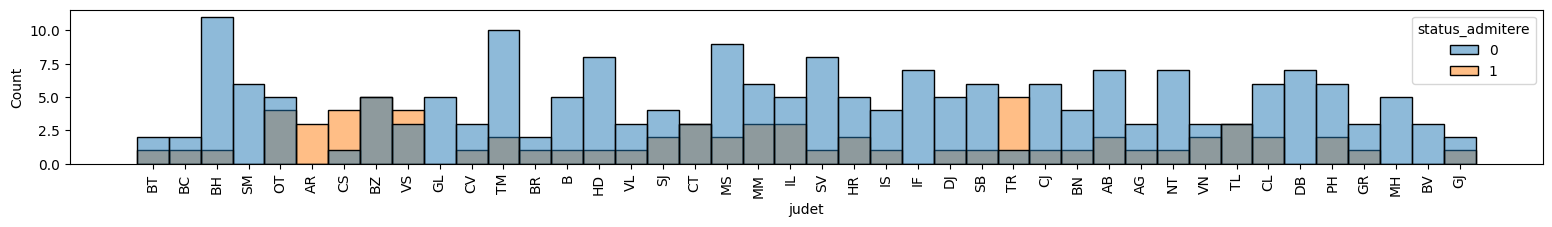

In [297]:
plt.figure(figsize=(19, 2))
plt.xticks(rotation=90)

sns.histplot(x="judet", data=df, hue='status_admitere')

# Models

In [298]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train, df["status_admitere"], test_size=0.2, random_state=seed
)

In [299]:
def evaluate(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1)
    cv = scores.mean() - scores.std()

    clf.fit(X_train, y_train)
    acc = clf.score(X_val, y_val)

    return cv, acc

In [300]:
rf = RandomForestClassifier(random_state=seed)

evaluate(rf)

(0.9390536388751436, 0.9814814814814815)

In [301]:
lr = LogisticRegression(max_iter=300, random_state=seed)

evaluate(lr)

(0.961045307581606, 0.9814814814814815)

In [302]:
clf = lr

clf.fit(X_train, y_train)

LogisticRegression(max_iter=300, random_state=42)

# Submission

In [303]:
df_test = pd.read_csv("test_data.csv")
df_test = clean_df(df_test)

features = prep_features(df_test)

In [304]:
# subtask 1
subtask1 = round(df_test["NT"] - df_test["MEV"], 2)

# ------------ subtask 2 ------------
# 1. sort by MEV descending
df2 = df_test[["id", "MEV"]].sort_values(by="MEV", ascending=False).reset_index(drop=True)

# 2. assign unique ranks 1…n
df2["rank"] = df2.index + 1

# 3. build a mapping { id → rank }
id_to_rank = dict(zip(df2["id"], df2["rank"]))

# 4. map back onto original rows
subtask2 = df_test["id"].map(id_to_rank).tolist()

# subtask 3
subtask3 = clf.predict(features)

In [305]:
def build_subtask(subtask_id, answer):
    return pd.DataFrame({
        "subtaskID": subtask_id, "datapointID": df_test["id"], "answer": answer
    })

subtasks = [
    (subtask1, 1),
    (subtask2, 2),
    (subtask3, 3)
]

submission = pd.concat(
    [build_subtask(sid, answer) for answer, sid in subtasks],
    ignore_index=True
)

submission.head()

,subtaskID,datapointID,answer
0,1,289,3.28
1,1,312,-1.00
2,1,423,-0.69
3,1,348,-0.74
4,1,415,-4.89


In [306]:
submission.to_csv("submission.csv", index=False)